<a href="https://colab.research.google.com/github/xtianu/TECM/blob/main/TECM_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TECM
# Course: SEGMENTATION

Christian Mata, Universitat Polotècnica de Catalunya, christian.mata@upc.edu

**SCHEDULE AND CONTENTS**

1. Workspace definition
2. Segmentation

    2.1. Unsupervised segmentation

    2.2. Supervised segmentation

3. Extraction of Regional features

# 1. Workspace definition


Read and display an image:

All the images can be downloaded from GitHub repository
https://github.com/xtianu/TECM

Firstly, it should load an image to Google Colab platform:

In [9]:
from google.colab import files # load skimage libraries
import io
uploaded = files.upload()

Saving mammograph.tif to mammograph.tif


Now, we read the image to get an array with the pixel intensity values ​​in each channel:

In [10]:
import skimage as sk # load skimage libraries
from skimage import io
I = sk.io.imread('mammograph.tif') # read image using imread function

To check the size of the image in pixels and the number of channels: 

In [11]:
I.shape

(1164, 984)

We can check how many bits are used to encode the intensity levels of each pixel:

In [12]:
I.dtype

dtype('uint8')

Now we can display the image:

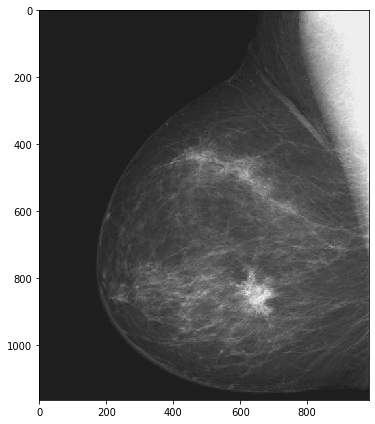

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sk.io.imshow(I) # visualize image using imshow function
sk.io.show()

### Reading an image using our google drive:

First we mount our google drive unit to be able to access it from google colab:

In [14]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/TECM/Curso/vessels_test.jpg'
I1 = sk.io.imread(file_path) # read image using imread function
I1.shape

(2336, 3504)

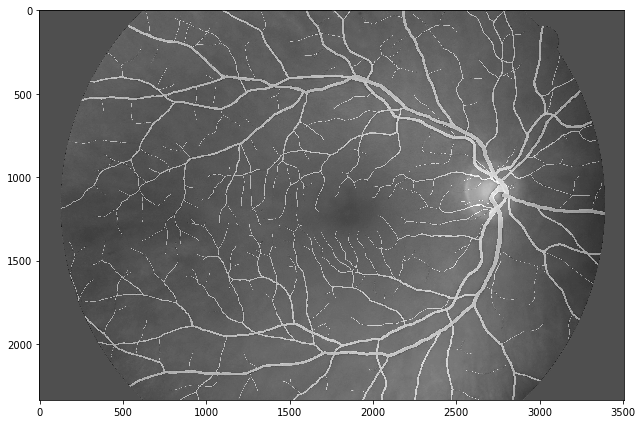

In [16]:
fig = plt.figure(figsize=(10,6))
sk.io.imshow(I1) # visualize image using imshow function
sk.io.show()

If we want to view both images at the same time:

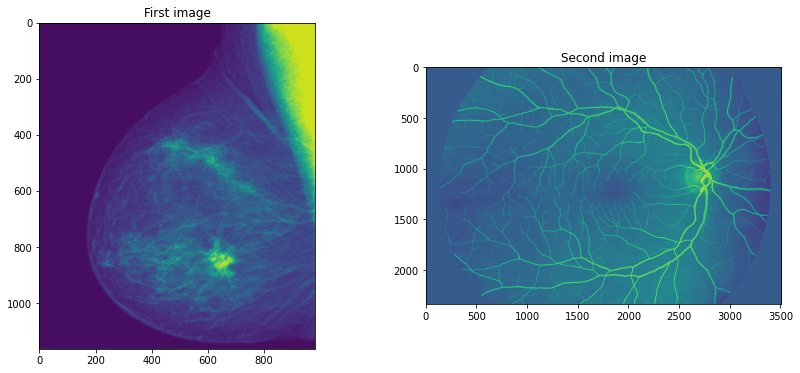

In [17]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(14, 6))
plt.subplot(121) 
plt.imshow(I) # visualize image using imshow function
plt.title('First image') 

plt.subplot(122)
plt.imshow(I1) # visualize image using imshow function
plt.title('Second image') 
plt.show()



You can save this figure with a .png format: 

In [18]:
plt.savefig('/content/drive/MyDrive/TECM/two_images.png')


<Figure size 432x288 with 0 Axes>

# 2. Object Segmentation

## Image segmentation: Supervised vs unsupervised approaches

Info:
https://healthdataminer.com/data-mining/aprendizaje-supervisado-y-no-supervisado/

Let's consider an image segmentation problem in which we should identify a pattern from the background. In this case, we only have two classes of pixels: pixels belonging to the background and pixels belonging to the pattern of interest (vessels in an image of the retina).

In order to understand the different methods covered in this session, we are going to use two different images from a well known dataset on retinal vessel segmentation:

- **Training image** ('vessels_train.jpg'): The one we are using in order to design the sementation method
- **Test image** ('vessels_test.jpg'): The image we are going to use in order to test the previously designed segmentation approach

For each of the images we also have their corresponding ground truth sementation images obtained from an independent expert ('vessels_train_GT.tif' and 'vessels_test_GT.tif'). The ground truth images are going to be used only when constructing a supervised approach. We will also use the GT images as reference in order to quantify the performance of the sementation method. 

First we take a look to the image dataset: 

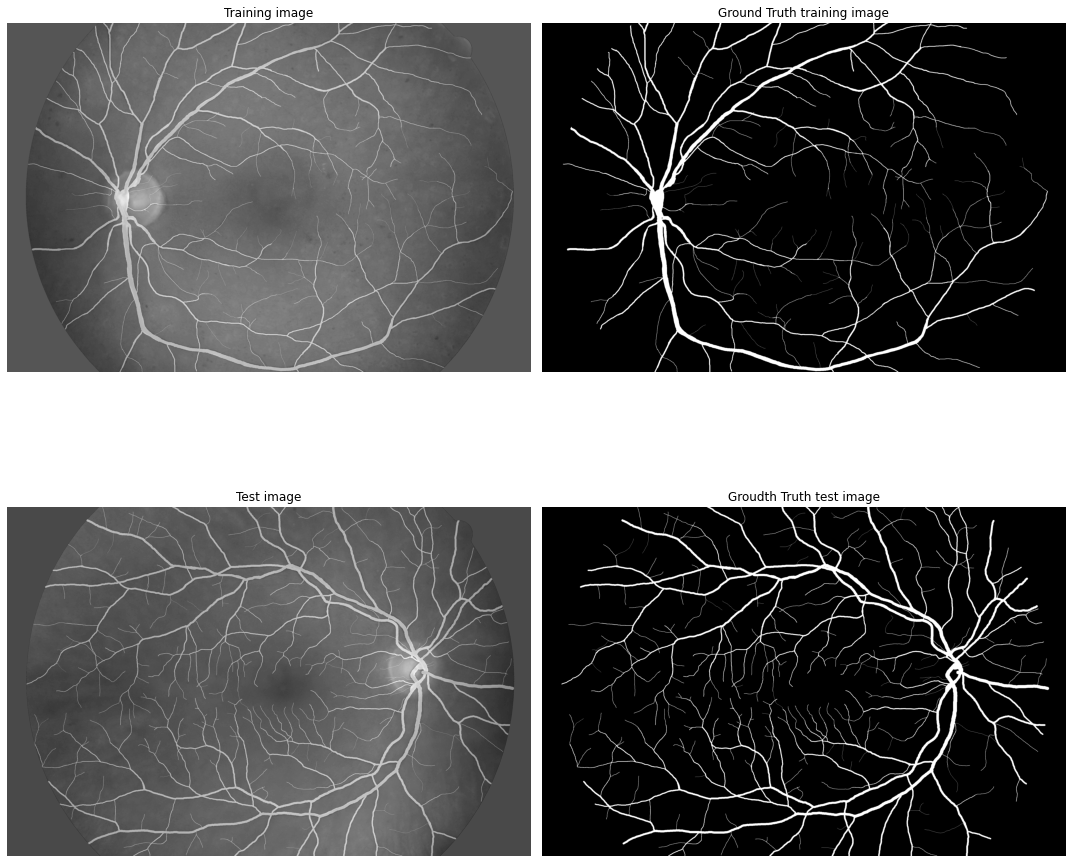

In [19]:
import skimage as sk 
import matplotlib.pyplot as plt
from skimage import io
import os 
from matplotlib import gridspec

# Path of the folder in your google drive unit where you have the images:
path = '/content/drive/MyDrive/TECM/Curso/'

I_train = sk.io.imread(os.path.join(path,'vessels_train.jpg')) 
I_train_GT = sk.io.imread(os.path.join(path,'vessels_train_GT.tif')) 
I_test = sk.io.imread(os.path.join(path,'vessels_test.jpg'))
I_test_GT = sk.io.imread(os.path.join(path,'vessels_test_GT.tif'))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Groudth Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

## 2.1. Unsupervised segmentation

- Otsu's algorithm


- K-means clustering


### Otsu's algorithm

Link: https://muthu.co/otsus-method-for-image-thresholding-explained-and-implemented/

As a reference, we will first apply well known segmentation approach Otsu's Method. The algorithm finds the threshold that **maximum inter-class variance** $\sigma _{b}^{2}(t)$, defined in terms of the difference between the means of the two clusters in the image histogram (pattern and background, respectively):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

The algorithm is the following: 

1. Compute histogram and probabilities of each intensity level $p(i), i=0,\dots L$ where $L=2^n$ for an n-bit grayscale image.

2. Set up initial $\omega _{i}(0)$ and $\mu _{i}(0)$ 

3. Step through all possible thresholds $t=1,\ldots L-1$ 

a) Update $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Compute $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

4. Desired threshold corresponds to the maximum inter-class variance $\sigma _{b}^{2}(t)$ 

ThOtsu value:  144


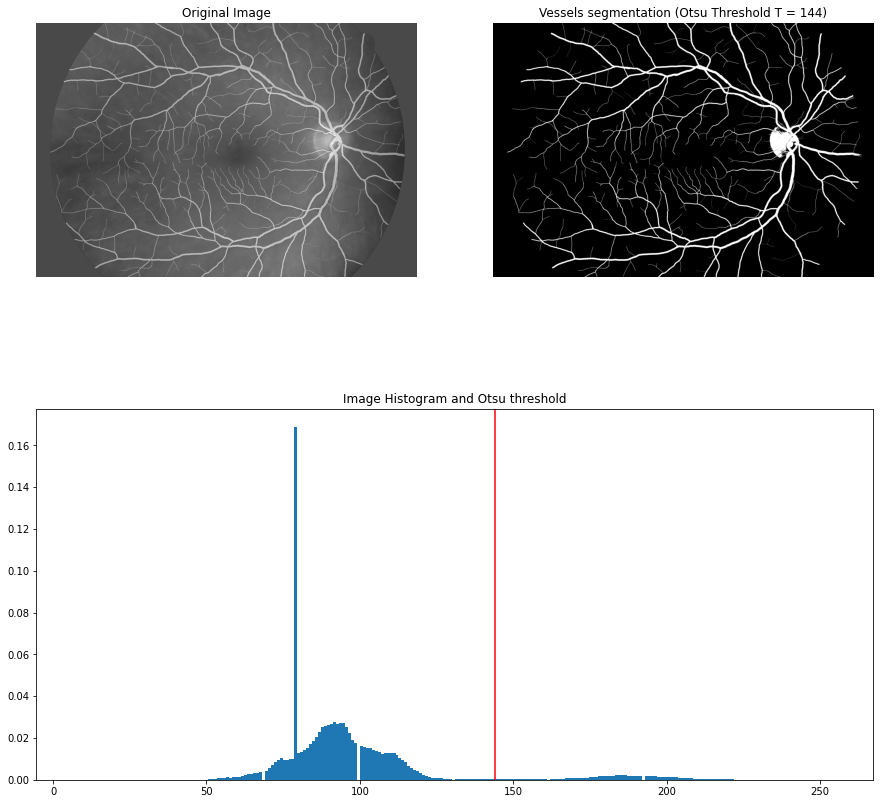

In [20]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)
print("ThOtsu value: ", threshold_otsu)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='r')
ax3.set_title('Image Histogram and Otsu threshold')
plt.show()

The peak in the histogram is due to the fact that the region outside circular lens has been previously replaced by the mean of the image.

### k-Means algorithm

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. 

k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids. 

**Link:** https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

Methodology:

  [1] Specify the number of clusters $k$ to be found in data.

  [2] Set initial values for the cluster centroids $\mu^0_1,\dots,\mu^0_k$ (at random or prior knowledge). 

  [3] Assign each observation to the nearest cluster (euclidean distance).

  [4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_k$.

  [5] Repeat steps 3-4 until no change in the centroids. Provide final clustering $\mu^n_1,\dots,\mu^n_k$, where $n$ is the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


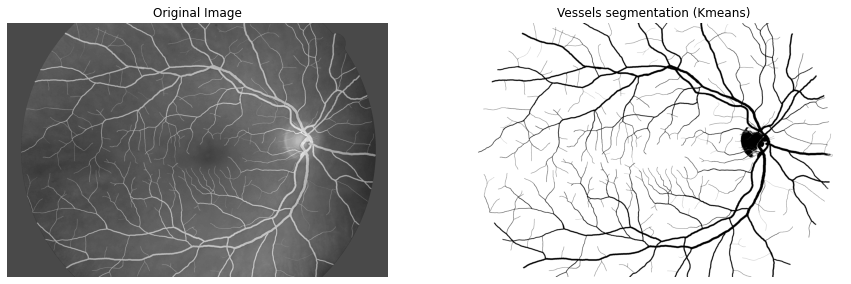

In [21]:
from sklearn.cluster import KMeans
import numpy as np

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test)
#v_kmeans= np.logical_not(v_kmeans) # use when the pattern is associated to cluster 0 (vessels should be white)
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

## 2.2. Supervised segmentation


### Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis or LDA is a dimensionality reduction technique. It is used as a pre-processing step in Machine Learning and applications of pattern classification. 

The goal of LDA is to project the features in higher dimensional space onto a lower-dimensional space in order to avoid the curse of dimensionality and also reduce resources and dimensional costs.

**Link:** https://www.knowledgehut.com/blog/data-science/linear-discriminant-analysis-for-machine-learning

**Methodology**

[1] Firstly, you need to calculate the separability between classes which is the distance between the mean of different classes. This is called the between-class variance.

[2] Secondly, calculate the distance between the mean and sample of each class. It is also called the within-class variance.

[3] Finally, construct the lower-dimensional space which maximizes the between-class variance and minimizes the within-class variance. P is considered as the lower-dimensional space projection, also called Fisher’s criterion.

<ipython-input-22-146ef05fe1b4>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool)


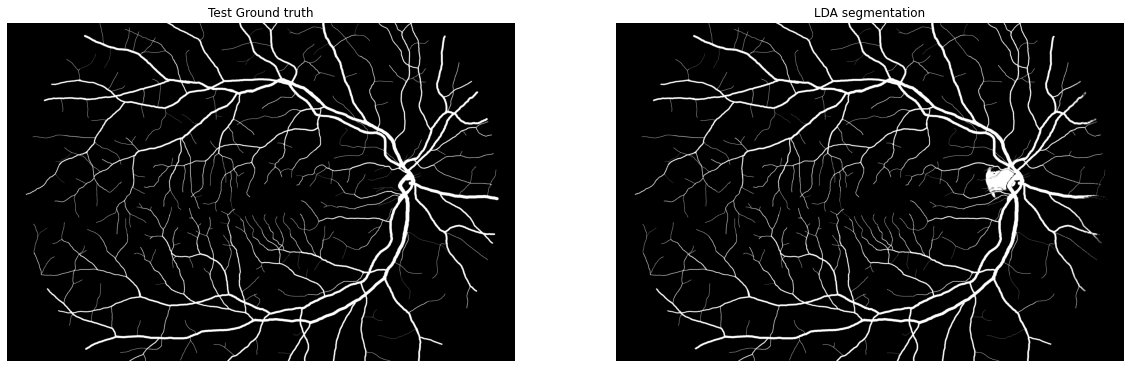

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool) 

lda_model = LinearDiscriminantAnalysis(store_covariance=True)
lda_model.fit(v_I_train, v_train_GT.ravel()) # Train with training image and training Ground Truth

# Predict the test image:
v_lda = lda_model.predict(v_I_test)
I_lda = np.array(v_lda).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(I_test_GT, cmap=plt.cm.gray)
ax[0].set_title('Test Ground truth')
ax[0].set_axis_off()

ax[1].imshow(I_lda, cmap=plt.cm.gray)
ax[1].set_title('LDA segmentation')
ax[1].set_axis_off()

plt.show()

## Performance evaluation


In order to evaluate a segmentation algorithm, we should introduce the following quantities:

- True positive (TP): A pattern pixel that has been correctly segmented as pattern
- True negative (TN): A background pixel that has been correctly segmented as background
- False positive (FP): A background pixel that has been mistakenly segmented as pattern (false alarm, Type I error)
- False negative (FN): A pattern pixel that has been mistakenly segmented as bavkground (omission, Type II error)

The confusion matrix is a 2x2 matrix reporting these four values: TP,TNFP,FN. 

From them we can define different measures of error: 

- Sensitivity, recall, hit rate, or true positive rate (TPR):

$\text{TPR} =\frac{TP}{TP+FN}$

- Specificity, selectivity or true negative rate (TNR):

$\text{TNR} =\frac{TN}{TN+FP}$

- The Sorensen-Dice similarity index: 

Measures the similarity between a segmentation mask and the ground truth mask by computing the F1 score
is the harmonic mean of precision and sensitivity:

$\text{DSC}={\frac {2TP}{2TP+FP+FN}}$.

In [23]:
from sklearn.metrics import confusion_matrix

v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool) 

CM_lda = confusion_matrix(v_test_GT,np.array(v_lda).astype(np.bool))

tn, fp, fn, tp = CM_lda.ravel()
TPR_lda = tp/(tp+fn)
FPR_lda = fp/(fp+tn)
DSC_lda = 2*tp/(2*tp+fp+fn)

print('LDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_lda,FPR_lda,DSC_lda))

<ipython-input-23-f682a76ef80f>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool)
<ipython-input-23-f682a76ef80f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CM_lda = confusion_matrix(v_test_GT,np.array(v_lda).astype(np.bool))


LDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


**Results**

In [24]:
CM_lda

array([[7614687,   23025],
       [   9242,  538390]])

In [25]:
print('LDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_lda,FPR_lda,DSC_lda))

LDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


# 3. Extraction of Regional features

Quantitative characterization of an image requires the extraction of relevant regional properties of the image. This process is known as **feature extraction**.

There are several feature extraction apporoaches and in this session we are going to cover the most important ones: 

- Basic regional properties: Based on region shape, intensity, color, size, etc.

- Advanced regional properties (texture analysis): Based on statistical properties of the distribution of pixels in the region: Homogeneity, entropy, uniformity, etc. 

Let's get started. 

## 3.1. Simple example: Artificial blobs

Generem una imatge amb blobs artificials:

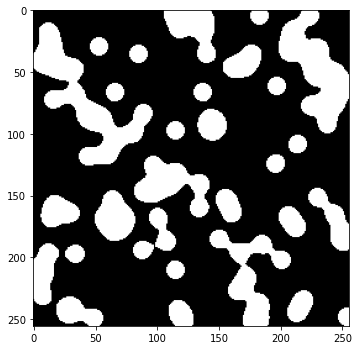

In [37]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

IG = data.binary_blobs(length=256, blob_size_fraction=0.1,volume_fraction=0.3)
fig = plt.figure(figsize=(5,5))
plt.imshow(IG,cmap='gray')
plt.tight_layout()
plt.show()

Segmentem, etiquetem regions i visualitzem:

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


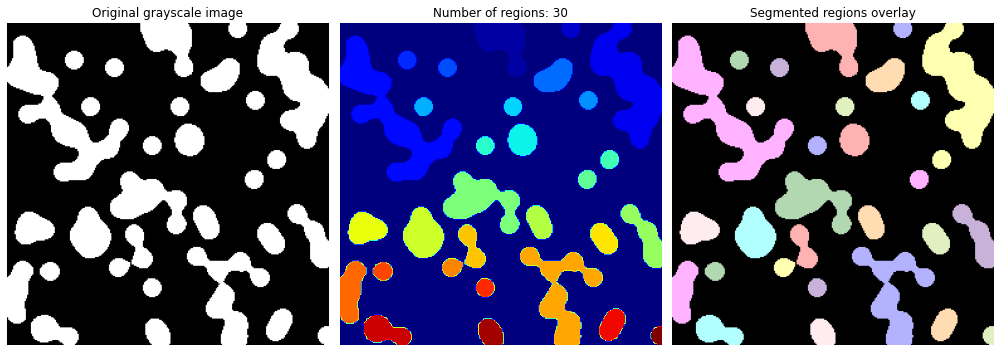

In [38]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb
from skimage.color import rgb2gray

# Apply Otsu threshold for segmentation :
thresh = threshold_otsu(IG)
bw = IG > thresh # keep lighter regions with grayscale intensities above threshold

# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=IG)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image') 
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay') 

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

Obtenir les propietats en forma de pandas dataframe

In [39]:
import pandas as pd

props = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent'])

df_propietats = pd.DataFrame(props)
df_propietats.head()


,label,area,eccentricity,extent
0,1,1093,0.789911,0.605205
1,2,152,0.588900,0.844444
2,3,2796,0.920213,0.490526
3,4,3390,0.928262,0.301280
4,5,177,0.000000,0.786667


<AxesSubplot:xlabel='eccentricity', ylabel='area'>

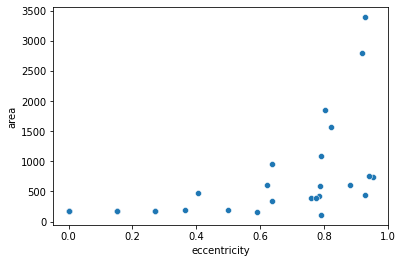

In [40]:
import seaborn as sns

sns.scatterplot(x='eccentricity',y='area',data=df_propietats)

## 3.2. Advanced example: Matches

### Step 1: Segmentation and labeling

In all regional feature extraction methods we should start from a semgented image with labelled regions or objects in an image:

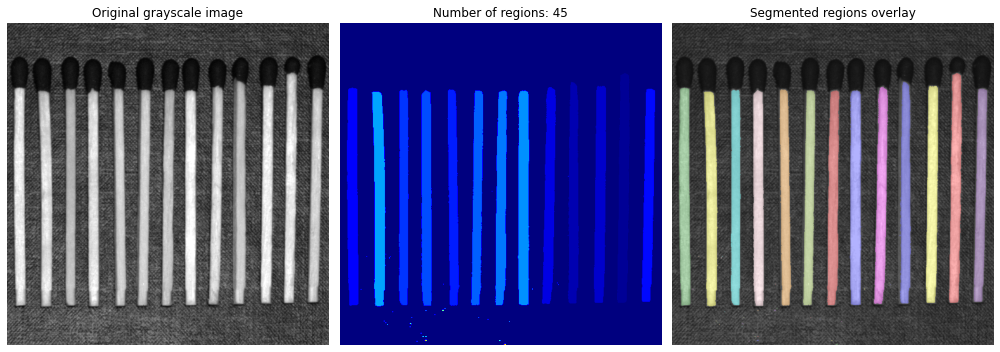

In [41]:
import matplotlib.pyplot as plt
import skimage as sk 
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb
from skimage.color import rgb2gray

IG = sk.io.imread('/content/drive/MyDrive/TECM/Curso/matches.tif') # read image using imread function

# Apply Otsu threshold for segmentation :
thresh = threshold_otsu(IG)
bw = IG > thresh # keep lighter regions with grayscale intensities above threshold

# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=IG)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image') 
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay') 

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

### Step 2: Obtain regional properties: 

Let's obtain the basic regional properties using the function regionprops: 

In [42]:
from skimage.measure import regionprops
import numpy as np 

props = regionprops(label_image)

Let's take a look to some of the available properties: For instance, for the region labelled as region 1 we have the following properties: 

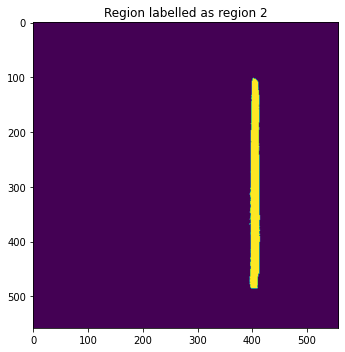

******* Region  2  *******
Area of Region: 6735 pixels
Centroiod of Region: (287.79346696362285, 491.1221974758723) 
Eccentricity of Region: 0.9990421943253247
Major Axis Length of Region: 450.74131008126204 pixels
Minor Axis Length of Region: 19.7231848940344 pixels
Perimeter of Region: 849.8650070512055 pixels
Orientation of Region: -0.013151214600322376 degrees


In [57]:
fig, ax = plt.subplots(figsize=(5, 5))
#Choosing the region
numregion=2
ax.imshow(label_image==numregion)
title = 'Region labelled as region ' + str(numregion)
ax.set_title(title) # set figure title
plt.tight_layout()
plt.show()

print('******* Region ',numregion,' *******')
print('Area of Region: {} pixels'.format(props[0].area))
print('Centroiod of Region: {} '.format(props[0].centroid))
print('Eccentricity of Region: {}'.format(props[0].eccentricity))
print('Major Axis Length of Region: {} pixels'.format(props[0].major_axis_length))
print('Minor Axis Length of Region: {} pixels'.format(props[0].minor_axis_length))
print('Perimeter of Region: {} pixels'.format(props[0].perimeter))
print('Orientation of Region: {} degrees'.format(props[0].orientation))

The complete list of basic properties with a detailed description of their meaning can be found in https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

### Step 3: Inspection of the regions: 

There are clearly too many regions (45), we shoud discard those correspoding to little sporious artefacts in the image. This becomes evident when we print the area itereting over regions. Note that the region number 1 is saved in props[0]. 

In [58]:
for ireg in range(0,nregions):
    print('Area of region {} is = {} pixels'.format(ireg+1, props[ireg].area))

Area of region 1 is = 6735 pixels
Area of region 2 is = 5936 pixels
Area of region 3 is = 6615 pixels
Area of region 4 is = 6184 pixels
Area of region 5 is = 6567 pixels
Area of region 6 is = 6004 pixels
Area of region 7 is = 5687 pixels
Area of region 8 is = 5600 pixels
Area of region 9 is = 6323 pixels
Area of region 10 is = 5827 pixels
Area of region 11 is = 6103 pixels
Area of region 12 is = 6637 pixels
Area of region 13 is = 6629 pixels
Area of region 14 is = 1 pixels
Area of region 15 is = 1 pixels
Area of region 16 is = 1 pixels
Area of region 17 is = 1 pixels
Area of region 18 is = 1 pixels
Area of region 19 is = 2 pixels
Area of region 20 is = 1 pixels
Area of region 21 is = 1 pixels
Area of region 22 is = 1 pixels
Area of region 23 is = 2 pixels
Area of region 24 is = 1 pixels
Area of region 25 is = 2 pixels
Area of region 26 is = 6 pixels
Area of region 27 is = 2 pixels
Area of region 28 is = 1 pixels
Area of region 29 is = 1 pixels
Area of region 30 is = 1 pixels
Area of re

It is obvious that regions with an area of few pixels should be considered as spourious artefacts of the segmentation. A reliable way of inspecting regional features is to represent the histogram of the features: 

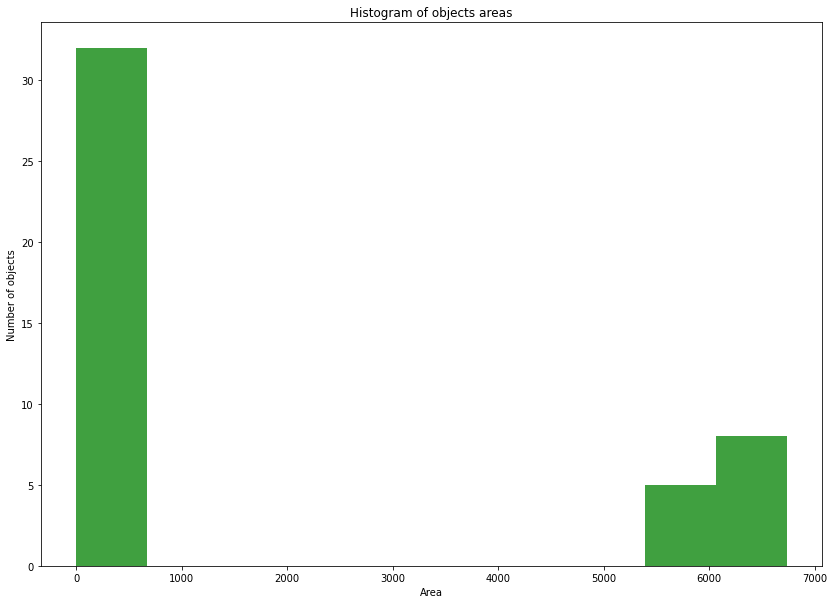

In [60]:
import numpy as np 

area = np.zeros(nregions)
for i in range(0,nregions):
    area[i] = props[i].area
   
# Plot histogram of the areas
fig = plt.figure(figsize=(14, 10))
n, bins, patches = plt.hist(area, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Area')
plt.ylabel('Number of objects')
plt.title('Histogram of objects areas')
plt.show()

Further inspection reveals that there are indeed around 32 objects with small area 13 with large areas. We now identify which small regions correspond to spourious artefacts presenting small areas below 3000 pixels:

In [61]:
ind_large = np.where(area > 3000)
ind_lregions = np.array(ind_large)+1 #Note: region 1 is placed in component 0 or the props variable
area_large = area[ind_large]
print('There are {} large objects'.format(len(area_large)))
print('Large objects correspond to regions: {}'.format(ind_lregions))
print('The areas of the large objects are: {}'.format(area_large))

ind_small = np.where(area < 3000)
area_small = area[ind_small]
ind_sregions = np.array(ind_small)+1
print('There are {} small objects'.format(len(area_small)))
print('Small objects correspond to regions: {}'.format(ind_sregions))
print('The areas of the small objects are {}'.format(area_small))

There are 13 large objects
Large objects correspond to regions: [[ 1  2  3  4  5  6  7  8  9 10 11 12 13]]
The areas of the large objects are: [6735. 5936. 6615. 6184. 6567. 6004. 5687. 5600. 6323. 5827. 6103. 6637.
 6629.]
There are 32 small objects
Small objects correspond to regions: [[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
  38 39 40 41 42 43 44 45]]
The areas of the small objects are [1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 2. 6. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1.
 1. 1. 2. 2. 5. 2. 1. 5.]


For instance, region labelled as 14 and its corresporing properties looks like this:

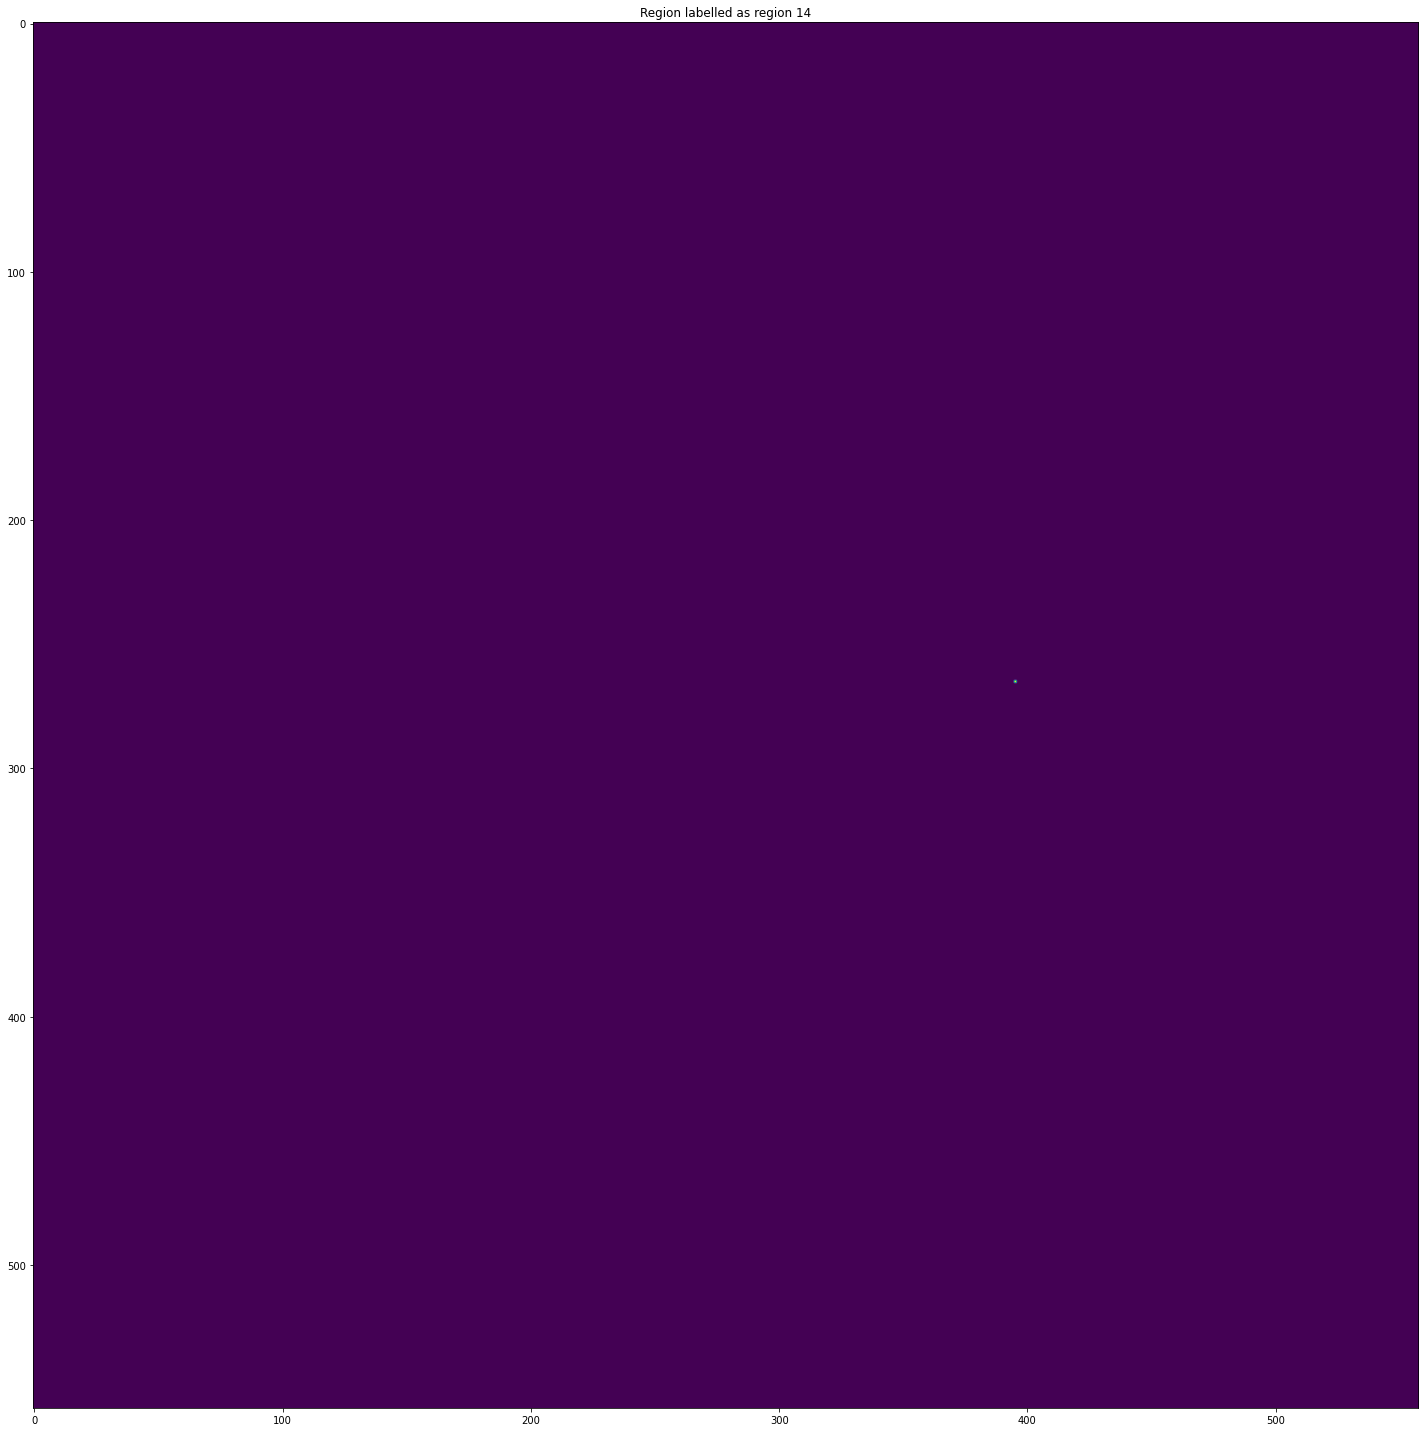

Area of Region 14: 1 pixels
Centroiod of Region 14: (265.0, 395.0) 
Eccentricity of Region 14: 0
Major Axis Length of Region 14: 0.0 pixels
Minor Axis Length of Region 14: 0.0 pixels
Perimeter of Region 14: 0.0 pixels
Orientation of Region 14: 0.7853981633974483 degrees


In [62]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(label_image==14)
ax.set_title('Region labelled as region 14') # set figure title
plt.tight_layout()
plt.show()

print('Area of Region 14: {} pixels'.format(props[13].area))
print('Centroiod of Region 14: {} '.format(props[13].centroid))
print('Eccentricity of Region 14: {}'.format(props[13].eccentricity))
print('Major Axis Length of Region 14: {} pixels'.format(props[13].major_axis_length))
print('Minor Axis Length of Region 14: {} pixels'.format(props[13].minor_axis_length))
print('Perimeter of Region 14: {} pixels'.format(props[13].perimeter))
print('Orientation of Region 14: {} degrees'.format(props[13].orientation))

### Step 4: Removal of spourious regions: 

Let's remove small objects from the labelled image so that we can work only with relevant objects in the image:

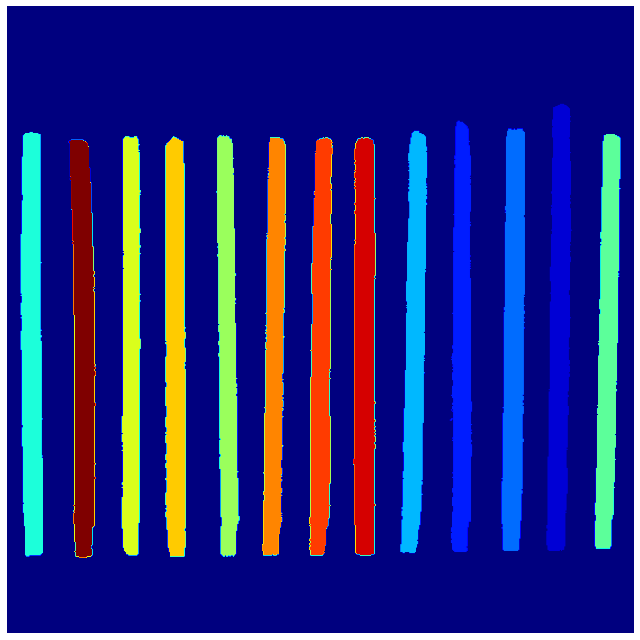

In [63]:
for i in np.squeeze(ind_small): # loop over small (spourious) regions
    iregion = i+1
    label_image[label_image==iregion]=0 # set spourious region as background by re-labelling as zero
    
image_label_overlay = label2rgb(label_image, image=IG) # generate again the colormap assignment

fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(label_image,cmap=plt.cm.jet)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Step 5: Obtain final region properties: 
Represent the **centroid and bounding box** of each object in the image:

The number of final regions is 13


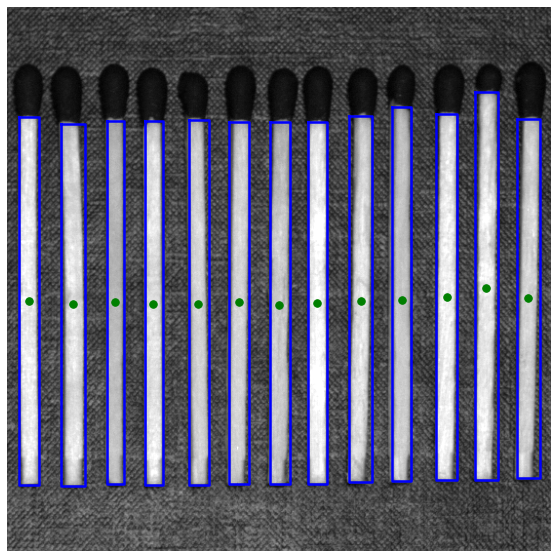

In [64]:
from skimage.measure import regionprops
import math

props = regionprops(label_image) # Obain again the properties after removal of spourious regions
print('The number of final regions is {}'.format(len(props)))

fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(IG, cmap=plt.cm.gray)

for p in props:
    y0, x0 = p.centroid
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = p.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.set_axis_off()
plt.show()

## 3.3. Texture extraction features:


Link: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html

Understanding the gray-level co-ocurrence matrix:

Each component of the co-ocurrence matrix g[i,j,d,theta] represents the number of times that grey-level j occurs at a distance d and at an angle theta from grey-level i:

In [65]:
from skimage.feature import greycomatrix

image = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
g = greycomatrix(image, [1], [0], levels=4, normed=False, symmetric=False)
print(image)
print('Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,0,0,0]))
print('Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,1,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,2,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,0,0,0]))

[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 3
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


/usr/local/lib/python3.8/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')


Once we have the GLCM we can compute the different texture properties:

Compute a feature of a grey level co-occurrence matrix to serve as a compact summary of the matrix. The properties are computed as follows:

- 'contrast': $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$

- 'dissimilarity': $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$

- 'homogeneity': $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$

- 'ASM': $\sum_{i,j=0}^{levels-1} P_{i,j}^2$

- 'energy':$\sqrt{ASM}$

- 'correlation': $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i) (j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

   

1. Obtain the gray-level co-ocurrence matrix of each of the regions in the image:

In [84]:
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
from skimage import data


props = regionprops(label_image,intensity_image=IG) # Obain again the properties after removal of spourious regions

nregions = len(props)
   
iregion = 0
props_texture = np.zeros((nregions,5))
for p in props:
    minr, minc, maxr, maxc = p.bbox
    I = IG[minc:maxc,minr:maxr]
    g = graycomatrix(I, [1], [0], levels=None, normed=True, symmetric=True)
    contrast = graycoprops(g, 'contrast')
    dissimilarity = graycoprops(g, 'dissimilarity')
    homogeneity = graycoprops(g, 'homogeneity')
    energy = graycoprops(g, 'energy')
    correlation = graycoprops(g, 'correlation')

    props_texture[iregion,0] = contrast
    props_texture[iregion,1] = dissimilarity
    props_texture[iregion,2] = homogeneity
    props_texture[iregion,3] = energy
    props_texture[iregion,4] = correlation

    iregion = iregion + 1 

# Export all features as a Pandas dataframe:
import pandas as pd
df = pd.DataFrame(props_texture,columns=['Contrast', 'dissimilarity','homogeneity','energy','correlation'])
df.to_excel("Texture_features.xlsx") 
df


,Contrast,dissimilarity,homogeneity,energy,correlation
0,193.105465,10.836491,0.094759,0.018133,0.929850
1,345.012533,12.844386,0.111022,0.021629,0.956752
2,333.493460,12.857270,0.102070,0.015937,0.955309
3,327.672222,12.236667,0.113407,0.018564,0.960499
4,128.309947,9.120292,0.102557,0.024563,0.696337
5,188.529773,10.965028,0.086201,0.020034,0.704618
6,307.925770,12.667558,0.098066,0.016163,0.960275
7,154.689753,9.001581,0.141326,0.024024,0.955489
8,284.106643,12.393506,0.092209,0.016595,0.962103
9,337.488897,13.076884,0.108817,0.024348,0.958346
